# AB Testing

[Kaggle Dataset Source:](https://www.kaggle.com/datasets/zhangluyuan/ab-testing?resource=download)

[Worked Example](https://towardsdatascience.com/ab-testing-with-python-e5964dd66143)

* Current conversion rate is about 13% on average throughout the year 
* The team would be happy with an increase of 2%
* Therefore the new design will be considered a success if it raises the conversion rate to 15%
* AB testing on a subset of users
* Hₒ: p = pₒ and Hₐ: p ≠ pₒ
* Confidence level of 95% so alpha = 0.05

Considerations:

* We need to be 95% confident the observed new conversion rate is statistically significantly different from the conversion rate of our old design, before rejecting the null Hₒ
* Control group - old design, treatment group - new design
* The group is the independent variable X and the conversion rate is the dependent variable y
* Number of user sessions in each group affects the precision of the conversion rate estimate - larger sample size then more precise the estimate (smaller confidence intervals) and higher likelihood of identifying a difference between groups.


## Import Data and Libraries

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import sem
import statsmodels.stats.api as sm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [30]:
df = pd.read_csv("C:/Users/imoge/Projects/Datasets/ab_data.csv")

## Data Preparation

In [31]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [32]:
df.shape

(294478, 5)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [34]:
# Convert timestamp to date object
df.timestamp = pd.to_datetime(df['timestamp'])
df['day'] = pd.DatetimeIndex(df['timestamp']).day
df.head()

,user_id,timestamp,group,landing_page,converted,day
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,21
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,12
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,11
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,8
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,21


## Data Exploration

In [46]:
# Visitor user_id duplicated - indicate multiple visits
df.user_id.duplicated().value_counts()

False    290584
True       3894
Name: user_id, dtype: int64

In [63]:
# Visits by day in January 2017
pd.DataFrame(df.day.value_counts()).sort_index()

,day
2,5783
3,13394
4,13284
5,13124
6,13528
7,13381
8,13564
9,13439
10,13523
11,13553


In [49]:
# Mean number of visits per day
df.day.value_counts().mean()

12803.391304347826

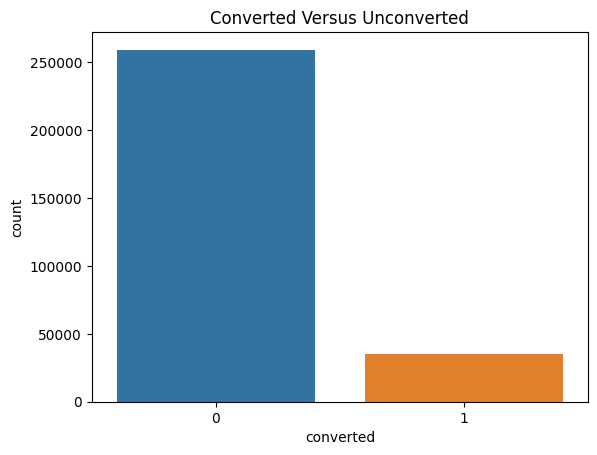

In [43]:
# Converted visits
sns.countplot(data = df, x = "converted")
plt.title("Converted Versus Unconverted");

In [68]:
# Conversion rate for both groups
round(((df["converted"] == 1).sum())/df.shape[0]*100,2)

11.97

In [89]:
# By group
control = df[df["group"]=="control"]
treat = df[df["group"] == "treatment"]

In [145]:
# Percentage conversion by group
print("Control Group Conversion:", control["converted"].value_counts()[1]/control.shape[0]*100)
print("Treatment Group Conversion:", treat["converted"].value_counts()[1]/treat.shape[0]*100)

Control Group Conversion: 12.039917935897611
Treatment Group Conversion: 11.891957956489856


Slight difference in conversion between the two groups

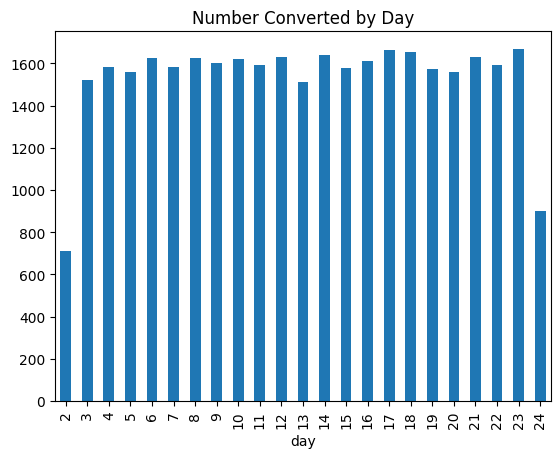

In [125]:
# Percent conversion by day
df[df["converted"]==1].groupby("day")["user_id"].count().plot(kind = "bar")
plt.title("Number Converted by Day");

In [141]:
con_df = pd.DataFrame(df[df["converted"]==1].groupby("day")["user_id"].count())
all_df = pd.DataFrame(df.groupby("day")["user_id"].count())
all_conv = pd.concat([con_df,all_df],axis = 1)
all_conv.columns = ["Converted","Total"]
all_conv["%Conv"]= round((all_conv["Converted"]/all_conv["Total"]*100),2)

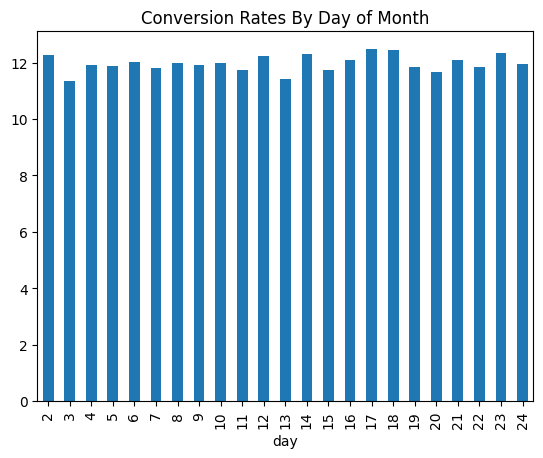

In [144]:
all_conv["%Conv"].plot(kind = "bar")
plt.title("Conversion Rates By Day of Month");

No real difference in conversion rates by day

## Take Sample

* Power of the test (1 — β) — the probability of finding a statistical difference between the groups when a difference is actually present. This is usually set at 0.8 by convention 
* Alpha value (α) — The critical value of 0.05
* Effect size — the difference we expect there to be between the conversion rates (in this case 2% per business case)

In [174]:
# Determine sample size
effect = sm.proportion_effectsize(0.13, 0.15)    # comparing two proportions

num = sms.NormalIndPower().solve_power(
    effect, 
    power=0.8, # 80% chance to detect a difference
    alpha=0.05, 
    ratio=1
    )                                                                                            

num = int(round(num,0))                          
print(num)

4719


In [158]:
# Duplicate users
session_counts = df['user_id'].value_counts(ascending=False)
session_counts.head()

805339    2
754884    2
722274    2
783176    2
898232    2
Name: user_id, dtype: int64

In [159]:
# Drop duplicate users
multi_users = session_counts[session_counts > 1].count()
drop_users = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(drop_users)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [176]:
# Sample from the cleaned data
control_sample = df[df['group'] == 'control'].sample(n=num, random_state=0)
treatment_sample = df[df['group'] == 'treatment'].sample(n=num, random_state=0)

In [203]:
# Concat the control and treatment sample back to a single dataframe
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop = True, inplace = True)
ab_test.head(2)

,user_id,timestamp,group,landing_page,converted,day
0,740761,2017-01-19 23:06:22.166842,control,old_page,0,19
1,685906,2017-01-15 13:37:19.383548,control,old_page,0,15


In [184]:
# Check the numbers in each group
ab_test["group"].value_counts()

control      4719
treatment    4719
Name: group, dtype: int64

In [185]:
# Check the datatypes
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9438 entries, 0 to 9437
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       9438 non-null   int64         
 1   timestamp     9438 non-null   datetime64[ns]
 2   group         9438 non-null   object        
 3   landing_page  9438 non-null   object        
 4   converted     9438 non-null   int64         
 5   day           9438 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 442.5+ KB


In [202]:
ab_test.head(2)

,user_id,timestamp,group,landing_page,converted,day
0,740761,2017-01-19 23:06:22.166842,control,old_page,0,19
1,685906,2017-01-15 13:37:19.383548,control,old_page,0,15


In [205]:
# Mean and standard devation of the control and treatment groups
ab_test.groupby('group')['converted'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,4719.0,0.11104,0.314216,0.0,0.0,0.0,0.0,1.0
treatment,4719.0,0.12100,0.326162,0.0,0.0,0.0,0.0,1.0


* Standard error of the mean (SEM) measures how far the sample mean of the data is likely to be from the true population mean. 
* Therefore it measures how much discrepancy is likely in a sample’s mean compared with the population mean.

In [206]:
# Standard error of the mean
print(sem(ab_test['group']=='control'))
print(sem(ab_test['group']=='treatment'))

0.00514698647236823
0.00514698647236823


The treatment group appears to have performed a little better on conversion rates

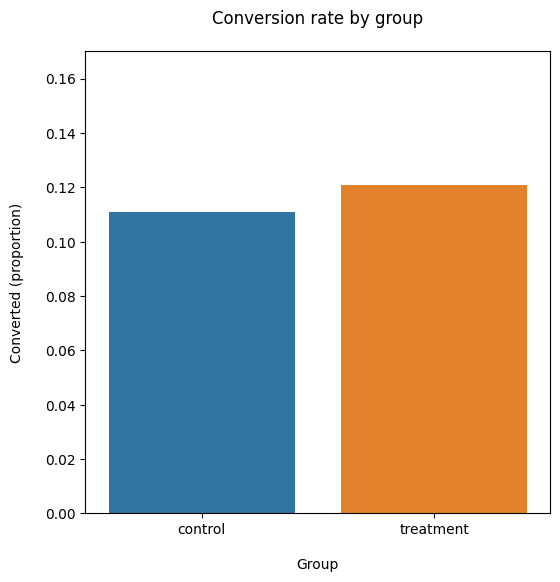

In [208]:
# Plot the two groups
plt.figure(figsize=(6,6))
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)
plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

## Statistical Significance of the Result

* Large sample so we can use the normal distribution
* If sample <30 then we would use the t-test

In [217]:
# Split into control and treatment groups
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

# Get the numbers of converts for each series of control and treatment groups
num_con = control_results.count()
num_treat = treatment_results.count()

# Determine the number of successful conversions and get the total in each group - to get proportions
successes = [control_results.sum(), treatment_results.sum()]
num_obs = [num_con, num_treat]

# get the z statistic, p-value for the successes as proportion of observations
z_stat, pval = proportions_ztest(successes, nobs=nobs)

# get the confidence intervals - upper and lower - for the control and treatment groups
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(successes, nobs=num_obs, alpha=0.05)

In [221]:
print("Z-statistic:",z_stat)
print("p-value:", pval)
print("\n")
print("Control Group:",lower_control, upper_control)
print("Treatment Group:",lower_treatment, upper_treatment)

Z-statistic: -1.5106702028079741
p-value: 0.13087249779105897


Control Group: 0.10207641475315872 0.1200045346005179
Treatment Group: 0.1116953367011709 0.13030508711743474


## Results

* The p-value is 0.13 which is above the α=0.05 threshold
* We cannot reject the Null hypothesis Hₒ
* The new design did not perform significantly differently to the old one
* The confidence interval for the new webpage group is 11.2 to 13.0 which just contains the 13% conversion rate but not the 15%
* Therefore we can conclude that the real conversion rate for the new webpage is similar to this baseline of 13%, so the new design is not really an improvement on the original webpage.